# Wasserstein Loss based Deep Convolutional GAN
## Dipack P Panjabi, 50291077, dipackpr@buffalo.edu
4 Convolutional layers, 64 filters multiplier for both generator and discriminator, batch-size 32 images (due to GPU VRAM constraints), 20 epochs (each using the entire CIFAR-10 dataset)

Spectral norm has been added to the generator, & discriminator
as it helps with the images generated, by reducing their blotchiness

In [1]:
%matplotlib inline
import os
import shutil
import logging
import torch as t
import torch.nn as tnn
import torch.optim as toptimizer
import torch.backends.cudnn as tcudnn
import torchvision.utils as tutils
from modules import FID
from util import setup_argparser, get_dataset, init_layer_weights, plot_losses, plot_fid_scores, clean_make_dir, save_best_generator_image, mean_fid

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p',
                    level=logging.INFO)

In [2]:
class WDCGenerator(tnn.Module):
    def __init__(self, latent_size=100, gen_hidden_units=64):
        super(WDCGenerator, self).__init__()
        self.l1 = tnn.Sequential(
            # Input layer
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(latent_size, out_channels=gen_hidden_units * 8, kernel_size=4, stride=1, padding=0, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 8),
            tnn.ReLU(True)
                )
        self.l2 = tnn.Sequential(
            # Layer 2
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 8, gen_hidden_units * 4, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 4),
            tnn.ReLU(True)
                )
        self.l3 = tnn.Sequential(
            # Layer 3
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 4, gen_hidden_units * 2, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 2),
            tnn.ReLU(True)
                )
        self.l4 = tnn.Sequential(
            # Layer 4
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 2, gen_hidden_units, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units),
            tnn.ReLU(True)
                )
        self.lout = tnn.Sequential(
            # Output Layer
            # CIFAR-10 reps RGB images, so there are 3 channels in the output
            # Changes made to the final layer to work with 32 * 32
            tnn.ConvTranspose2d(gen_hidden_units, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            tnn.Tanh()
                )
        return

    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.lout(output)
        return output

class WDCDiscriminator(tnn.Module):
    def __init__(self, latent_size=100, dis_hidden_units=64):
        super(WDCDiscriminator, self).__init__()
        self.l1 = tnn.Sequential(
                # Input layer
                tnn.utils.spectral_norm(tnn.Conv2d(in_channels=3, out_channels=dis_hidden_units, kernel_size=4, stride=2, padding=1, bias=False)),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l2 = tnn.Sequential(
                # Layer 1
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units, dis_hidden_units * 2, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 2),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l3 = tnn.Sequential(
                # Layer 2
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units * 2, dis_hidden_units * 4, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 4),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l4 = tnn.Sequential(
                # Layer 3
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units * 4, dis_hidden_units * 8, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 8),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.lout = tnn.Sequential(
                # Output Layer
                # Changes made to the final layer to work with 32 * 32
                tnn.Conv2d(dis_hidden_units * 8, 1, 2, 2, 0, bias=False),
                )
        return

    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.lout(output)
        return output.view(-1, 1).squeeze(1)

### Parameters

In [3]:
path             = "./cifar10"
output_path      = "./output/wdcgan"
learning_rate    = 0.0002
batch_size       = 32
latent_size      = 100
num_epochs       = 30
gen_hidden_units = 64
dis_hidden_units = 64
debug_info       = False
clean_dirs       = True
save_best        = True
critic_iters     = 5
log_interval     = 100
fid_batch_interval = 10

### Actual Model Run

19/10/2019 11:32:25 PM - INFO: Clean selected - removing: ./output/wdcgan
19/10/2019 11:32:25 PM - INFO: Creating output directory: ./output/wdcgan
19/10/2019 11:32:25 PM - INFO: Dataset path: ./cifar10, Output path: ./output/wdcgan, Batch Size: 32, Latent Size: 100, Num iterations: 30, Generator unit multiplier: 64, Discriminator unit multiplier: 64, Learning rate: 0.0002


Files already downloaded and verified
Files already downloaded and verified


19/10/2019 11:32:27 PM - INFO: CUDA enabled device found - will use CUDA device
19/10/2019 11:32:33 PM - INFO: WDCGenerator(
  (l1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

19/10/2019 11:45:15 PM - INFO: Epoch: 4/30, Sample: 1001/1562, Disc Loss: -0.3679, Gen Loss: 0.1838
19/10/2019 11:45:26 PM - INFO: Epoch: 4/30, Sample: 1101/1562, Disc Loss: -0.3706, Gen Loss: 0.1846
19/10/2019 11:45:32 PM - INFO: Epoch: 4/30, Sample: 1201/1562, Disc Loss: -0.3698, Gen Loss: 0.1845
19/10/2019 11:45:38 PM - INFO: Epoch: 4/30, Sample: 1301/1562, Disc Loss: -0.3700, Gen Loss: 0.1839
19/10/2019 11:45:45 PM - INFO: Epoch: 4/30, Sample: 1401/1562, Disc Loss: -0.3679, Gen Loss: 0.1833
19/10/2019 11:45:52 PM - INFO: Epoch: 4/30, Sample: 1501/1562, Disc Loss: -0.1952, Gen Loss: 0.0443
19/10/2019 11:47:39 PM - INFO: Epoch 4 FID score: 220.89485780068657
19/10/2019 11:47:39 PM - INFO: Epoch: 5/30, Sample: 1/1562, Disc Loss: -0.3622, Gen Loss: 0.1814
19/10/2019 11:47:45 PM - INFO: Epoch: 5/30, Sample: 101/1562, Disc Loss: -0.3688, Gen Loss: 0.1840
19/10/2019 11:47:52 PM - INFO: Epoch: 5/30, Sample: 201/1562, Disc Loss: -0.3695, Gen Loss: 0.1846
19/10/2019 11:47:59 PM - INFO: Epoch

20/10/2019 12:04:37 AM - INFO: Epoch: 9/30, Sample: 1001/1562, Disc Loss: -0.2738, Gen Loss: 0.0982
20/10/2019 12:04:44 AM - INFO: Epoch: 9/30, Sample: 1101/1562, Disc Loss: -0.3420, Gen Loss: 0.1723
20/10/2019 12:04:51 AM - INFO: Epoch: 9/30, Sample: 1201/1562, Disc Loss: -0.3639, Gen Loss: 0.1818
20/10/2019 12:04:58 AM - INFO: Epoch: 9/30, Sample: 1301/1562, Disc Loss: -0.3650, Gen Loss: 0.1817
20/10/2019 12:05:04 AM - INFO: Epoch: 9/30, Sample: 1401/1562, Disc Loss: -0.2416, Gen Loss: 0.1533
20/10/2019 12:05:11 AM - INFO: Epoch: 9/30, Sample: 1501/1562, Disc Loss: -0.3677, Gen Loss: 0.1837
20/10/2019 12:07:17 AM - INFO: Epoch 9 FID score: 170.31699809518625
20/10/2019 12:07:17 AM - INFO: Epoch: 10/30, Sample: 1/1562, Disc Loss: -0.3674, Gen Loss: 0.1837
20/10/2019 12:07:28 AM - INFO: Epoch: 10/30, Sample: 101/1562, Disc Loss: -0.0736, Gen Loss: 0.0169
20/10/2019 12:07:37 AM - INFO: Epoch: 10/30, Sample: 201/1562, Disc Loss: -0.1209, Gen Loss: 0.1258
20/10/2019 12:07:42 AM - INFO: Ep

20/10/2019 12:23:40 AM - INFO: Epoch: 14/30, Sample: 901/1562, Disc Loss: -0.1819, Gen Loss: 0.1665
20/10/2019 12:23:51 AM - INFO: Epoch: 14/30, Sample: 1001/1562, Disc Loss: -0.2001, Gen Loss: 0.1533
20/10/2019 12:24:02 AM - INFO: Epoch: 14/30, Sample: 1101/1562, Disc Loss: -0.3361, Gen Loss: 0.1711
20/10/2019 12:24:13 AM - INFO: Epoch: 14/30, Sample: 1201/1562, Disc Loss: -0.2248, Gen Loss: 0.1709
20/10/2019 12:24:23 AM - INFO: Epoch: 14/30, Sample: 1301/1562, Disc Loss: -0.1347, Gen Loss: -0.0323
20/10/2019 12:24:34 AM - INFO: Epoch: 14/30, Sample: 1401/1562, Disc Loss: -0.1806, Gen Loss: 0.1499
20/10/2019 12:24:45 AM - INFO: Epoch: 14/30, Sample: 1501/1562, Disc Loss: -0.1125, Gen Loss: 0.0289
20/10/2019 12:26:34 AM - INFO: Epoch 14 FID score: 118.56233422998407
20/10/2019 12:26:34 AM - INFO: Epoch: 15/30, Sample: 1/1562, Disc Loss: -0.1482, Gen Loss: 0.1517
20/10/2019 12:26:41 AM - INFO: Epoch: 15/30, Sample: 101/1562, Disc Loss: -0.0736, Gen Loss: 0.1440
20/10/2019 12:26:47 AM - 

20/10/2019 12:40:52 AM - INFO: Epoch: 19/30, Sample: 801/1562, Disc Loss: -0.1436, Gen Loss: 0.0553
20/10/2019 12:40:55 AM - INFO: Epoch: 19/30, Sample: 901/1562, Disc Loss: -0.3285, Gen Loss: 0.1634
20/10/2019 12:40:59 AM - INFO: Epoch: 19/30, Sample: 1001/1562, Disc Loss: -0.1374, Gen Loss: 0.1505
20/10/2019 12:41:02 AM - INFO: Epoch: 19/30, Sample: 1101/1562, Disc Loss: -0.0939, Gen Loss: 0.0013
20/10/2019 12:41:06 AM - INFO: Epoch: 19/30, Sample: 1201/1562, Disc Loss: -0.3120, Gen Loss: 0.1556
20/10/2019 12:41:09 AM - INFO: Epoch: 19/30, Sample: 1301/1562, Disc Loss: -0.0824, Gen Loss: 0.0014
20/10/2019 12:41:13 AM - INFO: Epoch: 19/30, Sample: 1401/1562, Disc Loss: -0.2015, Gen Loss: 0.1266
20/10/2019 12:41:16 AM - INFO: Epoch: 19/30, Sample: 1501/1562, Disc Loss: -0.2351, Gen Loss: 0.1388
20/10/2019 12:42:26 AM - INFO: Epoch 19 FID score: 102.59227239748175
20/10/2019 12:42:26 AM - INFO: Epoch: 20/30, Sample: 1/1562, Disc Loss: -0.1059, Gen Loss: 0.0764
20/10/2019 12:42:30 AM - I

20/10/2019 12:50:59 AM - INFO: Epoch: 24/30, Sample: 701/1562, Disc Loss: -0.0989, Gen Loss: -0.0518
20/10/2019 12:51:02 AM - INFO: Epoch: 24/30, Sample: 801/1562, Disc Loss: -0.0990, Gen Loss: 0.1544
20/10/2019 12:51:06 AM - INFO: Epoch: 24/30, Sample: 901/1562, Disc Loss: -0.0696, Gen Loss: 0.0444
20/10/2019 12:51:09 AM - INFO: Epoch: 24/30, Sample: 1001/1562, Disc Loss: -0.1370, Gen Loss: 0.1253
20/10/2019 12:51:13 AM - INFO: Epoch: 24/30, Sample: 1101/1562, Disc Loss: -0.0519, Gen Loss: 0.0897
20/10/2019 12:51:16 AM - INFO: Epoch: 24/30, Sample: 1201/1562, Disc Loss: -0.2022, Gen Loss: 0.0568
20/10/2019 12:51:20 AM - INFO: Epoch: 24/30, Sample: 1301/1562, Disc Loss: -0.1118, Gen Loss: 0.0268
20/10/2019 12:51:23 AM - INFO: Epoch: 24/30, Sample: 1401/1562, Disc Loss: -0.1408, Gen Loss: 0.0239
20/10/2019 12:51:27 AM - INFO: Epoch: 24/30, Sample: 1501/1562, Disc Loss: -0.0792, Gen Loss: -0.0153
20/10/2019 12:52:37 AM - INFO: Epoch 24 FID score: 93.57871935715725
20/10/2019 12:52:37 AM 

20/10/2019 01:01:07 AM - INFO: Epoch: 29/30, Sample: 601/1562, Disc Loss: -0.1063, Gen Loss: 0.0927
20/10/2019 01:01:10 AM - INFO: Epoch: 29/30, Sample: 701/1562, Disc Loss: -0.1097, Gen Loss: -0.0701
20/10/2019 01:01:14 AM - INFO: Epoch: 29/30, Sample: 801/1562, Disc Loss: -0.0618, Gen Loss: 0.1032
20/10/2019 01:01:17 AM - INFO: Epoch: 29/30, Sample: 901/1562, Disc Loss: -0.0945, Gen Loss: 0.1456
20/10/2019 01:01:21 AM - INFO: Epoch: 29/30, Sample: 1001/1562, Disc Loss: -0.1463, Gen Loss: 0.1000
20/10/2019 01:01:24 AM - INFO: Epoch: 29/30, Sample: 1101/1562, Disc Loss: -0.0751, Gen Loss: -0.0039
20/10/2019 01:01:28 AM - INFO: Epoch: 29/30, Sample: 1201/1562, Disc Loss: -0.0667, Gen Loss: -0.0306
20/10/2019 01:01:31 AM - INFO: Epoch: 29/30, Sample: 1301/1562, Disc Loss: -0.0817, Gen Loss: 0.1143
20/10/2019 01:01:35 AM - INFO: Epoch: 29/30, Sample: 1401/1562, Disc Loss: -0.1057, Gen Loss: 0.1265
20/10/2019 01:01:38 AM - INFO: Epoch: 29/30, Sample: 1501/1562, Disc Loss: -0.1261, Gen Loss

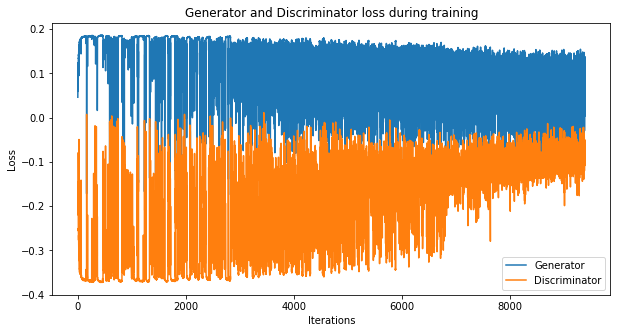

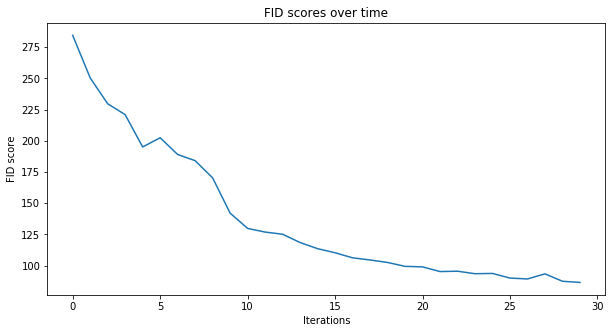

20/10/2019 01:04:52 AM - INFO: Generator model with lowest FID score is ./output/wdcgan/generator_epoch_30.pth
20/10/2019 01:04:52 AM - INFO: Saving output of best generator model to ./output/wdcgan/best_fake_sample.png


In [4]:
if clean_dirs:
    clean_make_dir(output_path)

logging.info("Dataset path: {}, Output path: {}, Batch Size: {}, Latent Size: {}, Num iterations: {}, Generator unit multiplier: {}, Discriminator unit multiplier: {}, Learning rate: {}".format(path, output_path, batch_size, latent_size, num_epochs, gen_hidden_units, dis_hidden_units, learning_rate))

training_dataset = get_dataset(path, train=True)
# Dropping the last batch as it is sometimes not divisible by batch_size,
# causing errors when trying to feed it to the GAN.
training_data_loader = t.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_dataset_path = "{0}/test".format(path)
testing_dataset = get_dataset(testing_dataset_path, train=False)
testing_data_loader = t.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_data_iter = iter(testing_data_loader)

device = t.device("cpu")
if t.cuda.is_available():
    logging.info("CUDA enabled device found - will use CUDA device")
    device = t.device("cuda:0")

# Init FID calculator
fid_calculator = FID(device=device)

gen_weights = None
generator = WDCGenerator(latent_size=latent_size, gen_hidden_units=gen_hidden_units).to(device)
generator.apply(init_layer_weights)
if gen_weights is not None:
    logging.info("Using weights saved at {} to continue Generator training".format(gen_weights))
    generator.load_state_dict(t.load(gen_weights))

dis_weights = None
discriminator = WDCDiscriminator(latent_size=latent_size, dis_hidden_units=dis_hidden_units).to(device)
discriminator.apply(init_layer_weights)
if dis_weights is not None:
    logging.info("Using weights saved at {} to continue Discriminator training".format(dis_weights))
    discriminator.load_state_dict(t.load(dis_weights))

logging.info(generator)
logging.info(discriminator)

noise = t.randn(batch_size, latent_size, 1, 1, device=device)

dis_optimizer = toptimizer.RMSprop(discriminator.parameters(), lr=learning_rate)
gen_optimizer = toptimizer.RMSprop(generator.parameters(), lr=learning_rate)

gen_filenames = []
gen_losses = []
dis_losses = []
fid_scores = []

# START - Training epoch loop
for epoch in range(num_epochs):
    # Variables to hold generated and fake images for FID score calc
    real_image_batch, fake_image_batch = None, None
    # START - Training batch loop
    for idx, data in enumerate(training_data_loader, start=0):
        # DISCRIMINATOR
        # Train discriminator network
        discriminator.zero_grad()
        # Real data
        real_images = data[0].to(device)
        # Batch size
        bs = real_images.size(0)

        output = discriminator(real_images)
        dis_err_real = output.mean()
        D_x = output.mean().item()

        # Train with fake data
        epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate fake images using noise
        fake_images = generator(epoch_noise)
        # Discriminator output for fake images
        output = discriminator(fake_images.detach())
        dis_err_fake = output.mean()
        # Discriminator output mean for fake images - before discriminator update
        D_G_z1 = output.mean().item()
        dis_err = -(dis_err_real - dis_err_fake)
        dis_err.backward()
        dis_optimizer.step()

        for param in discriminator.parameters():
            param.data.clamp_(-0.01, 0.01)

        if idx % critic_iters == 0:
            # GENERATOR
            # Train generator network
            generator.zero_grad()
            # Test discriminator again - this time after training it
            output = discriminator(fake_images)
            gen_err = - output.mean()
            gen_err.backward()
            # Discriminator output mean for fake images - after discriminator update
            D_G_z2 = output.mean().item()
            gen_optimizer.step()

            gen_losses.append(gen_err.item())
            dis_losses.append(dis_err.item())

        if idx % log_interval == 0:
            log_info = "Epoch: {}/{}, Sample: {}/{}, Disc Loss: {:.4f}, Gen Loss: {:.4f}".format(epoch + 1, num_epochs, idx + 1, len(training_data_loader), dis_err.item(), gen_err.item())
            if debug_info:
                log_info += ", D(x): {:.4f}, D(G(z)): {:.4f} / {:.4f}".format(D_x, D_G_z1, D_G_z2)
            logging.info(log_info)

        if idx % 100 == 0 or idx == (len(training_data_loader) - 1):
            tutils.save_image(real_images, "{0}/real_samples.png".format(output_path), normalize=True)
            fake_images = generator(noise)
            tutils.save_image(fake_images.detach(), "{0}/fake_samples_epoch_{1}.png".format(output_path, epoch + 1), normalize=True)
        
        if idx % fid_batch_interval == 0:
            # Add to fake image batch for FID score calc
            if fake_image_batch is None:
                fake_image_batch = fake_images.detach()
            else:
                fake_image_batch = t.cat((fake_image_batch, fake_images.detach()), dim=0)
    # END - Training batch loop

    g_weight_filename = "{0}/generator_epoch_{1}.pth".format(output_path, epoch + 1)
    gen_filenames.append(g_weight_filename)
    # Checkpoint model
    t.save(generator.state_dict(), g_weight_filename)
    t.save(discriminator.state_dict(), "{0}/discriminator_epoch_{1}.pth".format(output_path, epoch + 1))

    # Calculate FID scores after each epoch - as it is super slow during normal iterations
    while real_image_batch is None or len(real_image_batch) < len(fake_image_batch):
        try:
            r_im, _ = next(testing_data_iter)
            r_im.to(device=device)
            if real_image_batch is None:
                real_image_batch = r_im
            else:
                real_image_batch = t.cat((real_image_batch, r_im), dim=0)
        except StopIteration:
            testing_data_iter = iter(testing_data_loader)
    fid_score = fid_calculator.calculate_fid(real_image_batch, fake_image_batch, batch_size)
    fid_scores.append(fid_score)
    logging.info("Epoch {} FID score: {}".format(epoch + 1, fid_score))
# END - Training epoch loop

logging.info("FID scores over the epochs: {}".format(fid_scores))
logging.info("Mean FID score: {}".format(mean_fid(fid_scores)))
plot_losses(gen_losses, dis_losses)
plot_fid_scores(fid_scores)

if save_best:
    save_best_generator_image(generator, gen_filenames, fid_scores, noise, output_path)


20/10/2019 01:04:52 AM - INFO: Last image generated


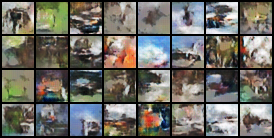

20/10/2019 01:04:52 AM - INFO: Image generated from model with lowest FID score


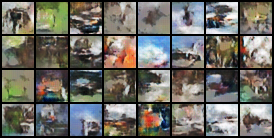

In [5]:
from IPython.display import Image, display

logging.info("Last image generated")
display(Image(filename="{0}/fake_samples_epoch_{1}.png".format(output_path, num_epochs)))
if save_best:
    logging.info("Image generated from model with lowest FID score")
    display(Image(filename="{0}/best_fake_sample.png".format(output_path)))